In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
with open('../names.txt', 'r') as file:
    names = file.read().split()

print('Total names:', len(names))
print(names[:5])

Total names: 32033
['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [5]:
# Form stoi and itos
vocab = sorted(list(set(''.join(names))))
stoi = {s: i+1 for i, s in enumerate(vocab)}
stoi['.'] = 0
itos = {stoi[s]: s for s in stoi}

vocab_size = len(stoi)

In [6]:
block_size = 3

In [7]:
def form_dataset(words):
    X = []
    Y = []

    for word in words:
        word = ['.'] * block_size + list(word) + ['.']
        for ind in range(3, len(word)):
            X.append([stoi[x] for x in word[ind-3:ind]])
            Y.append(stoi[word[ind]])
            # print(''.join(word[ind-3:ind]), '--->', word[ind])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

### Form dataset
Divide into 3: usual splits are 80, 10, 10

In [8]:
import random
random.seed(42)
random.shuffle(names)

X, Y = form_dataset(names)

n1 = int(0.8 * X.shape[0])
n2 = int(0.9 * X.shape[0])
Xtr, Xdev, Xts = X.tensor_split((n1, n2), dim=0) # input is split into X[:n1], X[n1:n2] and X[n2:]
Ytr, Ydev, Yts = Y.tensor_split((n1, n2), dim=0)
print(Ytr.shape, Ydev.shape, Yts.shape)

torch.Size([182516]) torch.Size([22815]) torch.Size([22815])


### Embedding data

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embd,             generator=g)
W1 = torch.randn(block_size * n_embd, n_hidden, generator=g) * 0.2
# b1 = torch.randn(n_hidden,                      generator=g) * 0.01

W2 = torch.randn(n_hidden, vocab_size,          generator=g) * 0.1 # Output of emb @ W1 + b1 will feed into W2 for multiplication
b2 = torch.randn(vocab_size,                    generator=g) * 0


bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
bnmean_running = bngain = torch.ones(1, n_hidden)
bnstd_running = bngain = torch.ones(1, n_hidden)

In [119]:
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
total_params = 0
for p in parameters:
    total_params += p.nelement()
    p.requires_grad = True

lossi = []

In [ ]:
# 27 characters. If equally distributed, anyone of them could be equally likely. But in settings, we started with ~25 loss value. 
expected_loss = -torch.log(torch.tensor(1/27.0))
expected_loss.item()

In [50]:
# Need unit gaussian distribution of hpreact at the time of initialialization of nn
# After initialization, distribution should still be more or less gaussian, but some variance should be added, so that we don't force

print(hpreact.shape)
res = bngain * ((hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True))
print(res.shape)

torch.Size([32, 200])
torch.Size([32, 200])


In [ ]:
batch_size = 32 # Take 32 training data points for each loop of gradient descend

for _ in range(100000):
    # mini batch construction
    batch_inds = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,))
    Xb, Yb = Xtr[batch_inds], Ytr[batch_inds]
    
    # Forward pass
    embs = C[Xb]
    embcat = embs.view(-1, block_size * n_embd)
    hpreact = embcat @ W1   # + b1 # hpreact: hidden layer pre activation
    
    # Batch normalization
    hmean = hpreact.mean(0, keepdim=True)
    hstd = hpreact.std(0, keepdim=True)
    hpreact = bngain * ((hpreact - hmean) / hstd) + bnbias
    
    with torch.no_grad():
        bnmean_running = bnmean_running * 0.999 + hmean * 0.001 # 0.001 is known as momentum in the pytorch initialization
        bnstd_running = bnstd_running * 0.999 + hstd * 0.001

    # tanh activation
    h = torch.tanh(hpreact)
    
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # print(loss.item())
    lossi.append(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Updating weights
    for p in parameters:
        p.data += -0.05 * p.grad

print(loss.item())

2.559446096420288


In [ ]:
# Calculating for single data point
print(logits[0])
counts = logits[0].exp()

probs = counts / counts.sum()
print(probs)
print(Yb[0], probs[Yb[0]]) # After first iteraction calculated probability of expected character is really really low. Hence, high value of loss

# counts & probability should be uniform - not too high or too low
# Look at exp(x) graph

# Maybe because logits are too extreme. We need to bring them closer to 0


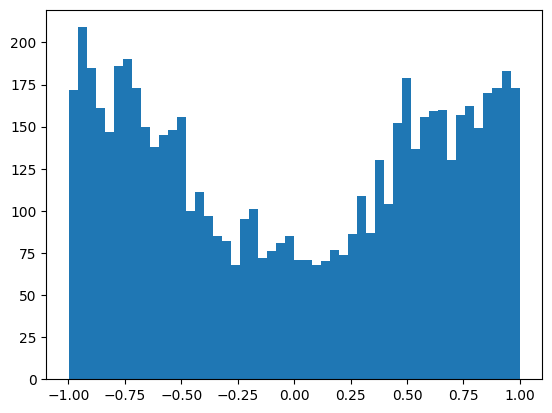

In [122]:
plt.hist(h.view(-1).tolist(), 50);

In [ ]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
counts = logits.exp()
probs = counts / counts.sum()
counts
probs

In [ ]:
plt.plot(lossi)

Basic settings with loss values: 0.1, 0.01 & 0.05 and over 10K+ iterations
loss = 2.078784942626953 


In [123]:
@torch.no_grad() # This disables gradient tracking which is required for back-propagation
def split_loss(X, Y):
    embs = C[X]
    embs = embs.view(-1, n_embd * block_size)
    hpreact = embs @ W1 + b1
    hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

In [127]:
print('Dev loss:', split_loss(Xdev, Ydev))
print('Test loss:', split_loss(Xts, Yts))

Dev loss: 2.143235206604004
Test loss: 2.146559000015259
